In [1]:
require(tidyverse)
require(data.table)

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.1  
✔ tibble  2.0.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [2]:
sscore_f <- '/oak/stanford/groups/mrivas/projects/PRS/private_output/snpnet_PRS/HC_20190303/8_score_all/HC382.sscore'
sscore_df <- fread(
    cmd=paste0('cat ', sscore_f, ' | cut -f2,6'), sep='\t', data.table=F
)


In [5]:
phe_f <- '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/highconfidenceqc/phe/HC382.phe'
phe_df <- fread(
    cmd=paste0('cat ', phe_f, ' | cut -f2,3'), sep='\t', data.table=F
)
colnames(phe_df) <- c('IID', 'HC382')


In [31]:
combined_df <- sscore_df %>% rename(snpnet_PRS = SCORE1_AVG) %>% 
left_join(phe_df, by='IID') %>%
rename(outcome = HC382) %>% 
filter(outcome != -9) %>%
drop_na() %>%
mutate(Percentile = rank(-snpnet_PRS) / n())


In [32]:
combined_df %>% dim()

[1] 488374      4

In [34]:
cnt_middle <- combined_df %>% 
filter(0.4 <= Percentile, Percentile <= 0.6) %>% 
count(outcome) %>% rename(n_40_60 = n)

In [35]:
cnt_middle

outcome,n_40_60
1,87152
2,10522


In [154]:
compute_or <- function(df){
    joined_df <- df %>% count(outcome) %>% inner_join(cnt_middle, by='outcome') %>% gather(bin, cnt, -outcome)
    n_TP <- .5 + joined_df %>% filter(bin == 'n', outcome == 2) %>% select(cnt) %>% pull()
    n_TN <- .5 + joined_df %>% filter(bin != 'n', outcome == 1) %>% select(cnt) %>% pull()
    n_FP <- .5 + joined_df %>% filter(bin != 'n', outcome == 2) %>% select(cnt) %>% pull()
    n_FN <- .5 + joined_df %>% filter(bin == 'n', outcome == 1) %>% select(cnt) %>% pull()
    or <- (n_TP * n_TN) / (n_FP * n_FN)
    lor <- log(or)
    se_lor <- sqrt((1/n_TP) + (1/n_TN) + (1/n_FP) + (1/n_FN))
    OR_l <- exp(lor - 1.96 * se_lor)
    OR_u <- exp(lor + 1.96 * se_lor)
    c(or, OR_l, OR_u, n_TP / (n_TP + n_FN), n_TP, n_FN)
#     %>% print()    
}

In [155]:
compute_or_wrapper <- function(idx, df){
    bin_u = 1 - idx * 0.1
    bin_l = 1 - (idx + 1) * 0.1
    c(
        1 - bin_u, 1 - bin_l, 
        df %>% filter(bin_l < Percentile, Percentile <= bin_u) 
        %>% compute_or()
    )    
}

In [156]:
res <- lapply(0:9, compute_or_wrapper, combined_df)

In [157]:
df <- as.data.frame(res) 
colnames(df) <- lapply(0:9, function(x){x * 10 + 5})
rownames(df) <- c(
    'l', 'u', 'OR', 'OR_l', 'OR_u', 
    'Prevalence', 
    'n_cases', 'n_conts'
)
dff <- df %>%
rownames_to_column('id')

In [158]:
dff %>% fwrite('HC382.csv', col.names=T)

In [159]:
dff

id,5,15,25,35,45,55,65,75,85,95
l,0.000000e+00,1.000000e-01,2.000000e-01,3.000000e-01,4.000000e-01,5.000000e-01,0.600000,7.000000e-01,8.000000e-01,9.000000e-01
u,1.000000e-01,2.000000e-01,3.000000e-01,4.000000e-01,5.000000e-01,6.000000e-01,0.700000,8.000000e-01,9.000000e-01,1.000000e+00
OR,4.350844e-01,5.670729e-01,6.945193e-01,8.042381e-01,9.162376e-01,1.085387e+00,1.259043,1.576238e+00,2.073247e+00,3.757104e+00
OR_l,4.157420e-01,5.440308e-01,6.680392e-01,7.748663e-01,8.839596e-01,1.048781e+00,1.218046,1.527299e+00,2.011959e+00,3.653915e+00
OR_u,4.553267e-01,5.910909e-01,7.220491e-01,8.347233e-01,9.496941e-01,1.123271e+00,1.301420,1.626744e+00,2.136401e+00,3.863206e+00
Prevalence,4.990888e-02,6.407920e-02,7.736645e-02,8.850690e-02,9.960482e-02,1.158626e-01,0.131954,1.598825e-01,2.002027e-01,3.120623e-01
n_cases,2.437500e+03,3.129500e+03,3.778500e+03,4.322500e+03,4.864500e+03,5.658500e+03,6444.500000,7.808500e+03,9.777500e+03,1.524050e+04
n_conts,4.640150e+04,4.570850e+04,4.506050e+04,4.451550e+04,4.397350e+04,4.317950e+04,42394.500000,4.103050e+04,3.906050e+04,3.359750e+04


In [161]:
combined_df %>% head()

IID,snpnet_PRS,outcome,Percentile
-1,-1.55788e-05,1,0.31376466
-2,-3.40738e-05,2,0.60200686
-5,-4.74612e-05,1,0.78891894
-6,-2.60698e-05,1,0.47415710
1000028,1.49198e-05,1,0.04441064
1000034,-4.58246e-05,1,0.76918714


In [170]:
keep_val <- '../../private_output/snpnet_PRS/HC_20190303/1_split/HC382.val' %>%
fread(sep='\t', col.names=c('FID', 'IID')) %>% select(IID) %>% mutate(split = 'val')

keep_test <- '../../private_output/snpnet_PRS/HC_20190303/1_split/HC382.test' %>%
fread(sep='\t', col.names=c('FID', 'IID')) %>% select(IID) %>% mutate(split = 'test')

keep_train <- '../../private_output/snpnet_PRS/HC_20190303/1_split/HC382.train' %>%
fread(sep='\t', col.names=c('FID', 'IID')) %>% select(IID) %>% mutate(split = 'train')

In [173]:
split_df <- bind_rows(keep_train, keep_val, keep_test)

In [174]:
split_df %>% count(split)

split,n
test,67438
train,202322
val,67438


In [185]:
combined_split_df <- combined_df %>% inner_join(split_df, by='IID')

In [178]:
combined_test_df <- combined_df %>% inner_join(split_df, by='IID') %>% filter(split == 'test')

In [179]:
combined_test_df %>% head()

IID,snpnet_PRS,outcome,Percentile,split
1000028,1.49198e-05,1,0.04441064,test
1000045,-2.45317e-05,1,0.45000553,test
1000052,-2.39723e-05,1,0.44111890,test
1000091,-4.10638e-05,1,0.70627019,test
1000133,1.94673e-05,1,0.02981731,test
1000246,-1.09432e-05,1,0.25112107,test


In [ ]:
pred <- prediction( ROCR.simple$predictions, ROCR.simple$labels)
perf <- performance(pred,"tpr","fpr")
plot(perf)

In [162]:
require(ROCR)

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [190]:
pred_ROCR <- prediction(
    combined_split_df %>% filter(split == 'val') %>% select(snpnet_PRS) %>% pull(), 
    combined_split_df %>% filter(split == 'val') %>% select(outcome) %>% pull()
)
auc_ROCR <- performance(pred_ROCR, measure = "auc")
auc_ROCR@y.values[[1]]

[1] 0.6066338

In [191]:
pred_ROCR <- prediction(
    combined_split_df %>% filter(split == 'train') %>% select(snpnet_PRS) %>% pull(), 
    combined_split_df %>% filter(split == 'train') %>% select(outcome) %>% pull()
)
auc_ROCR <- performance(pred_ROCR, measure = "auc")
auc_ROCR@y.values[[1]]

[1] 0.7767586

In [192]:
pred_ROCR <- prediction(
    combined_split_df %>% filter(split == 'test') %>% select(snpnet_PRS) %>% pull(), 
    combined_split_df %>% filter(split == 'test') %>% select(outcome) %>% pull()
)
auc_ROCR <- performance(pred_ROCR, measure = "auc")
auc_ROCR@y.values[[1]]

[1] 0.6112024

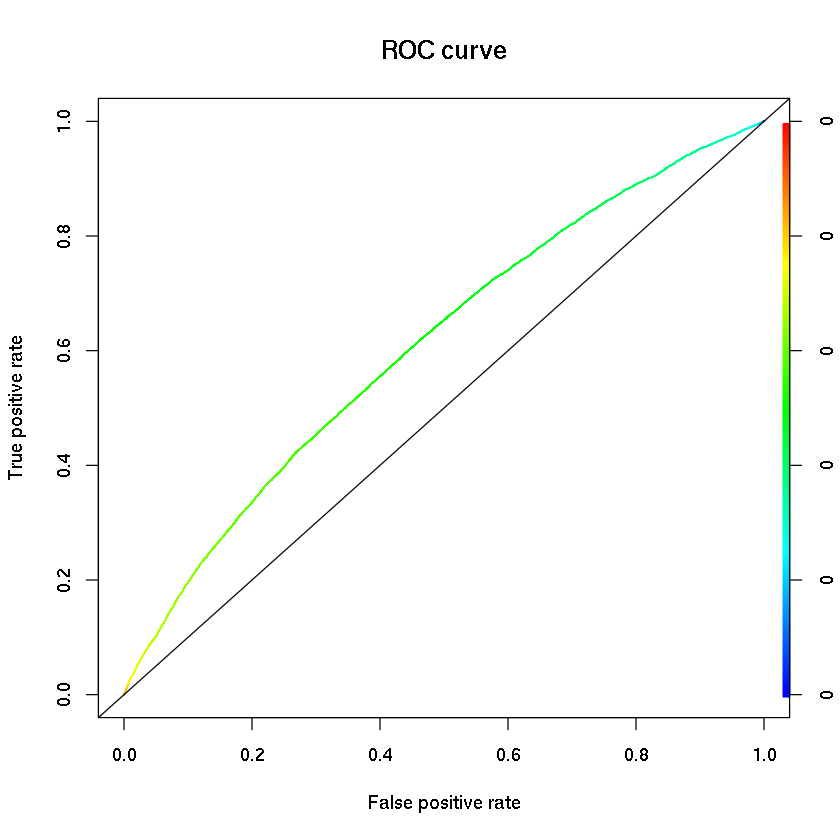

In [193]:
roc_ROCR <- performance(pred_ROCR, measure = "tpr", x.measure = "fpr")
plot(roc_ROCR, main = "ROC curve", colorize = T)
abline(a = 0, b = 1)
